In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [218]:
# Load data as a Pandas dataframe
# Adjust filepath depending on where the data is stored on your end
data = pd.read_csv("Desktop/GitHub/BreastCancer/breast-cancer-wisconsin.csv",
                  names=["ID Number","Clump Thickness","Cell Size Uniformity",
                        "Cell Shape Uniformity","Marginal Adhesion",
                         "Epithelial Cell Size","Bare Nuclei","Bland Chromatin",
                         "Normal Nucleoli", "Mitosis","Class"])

In [219]:
data.head()

,ID Number,Clump Thickness,Cell Size Uniformity,Cell Shape Uniformity,Marginal Adhesion,Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitosis,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


# Data pre-processing

Check for null/empty values

In [220]:
missing = data.isnull().sum()
missing

ID Number                0
Clump Thickness          0
Cell Size Uniformity     0
Cell Shape Uniformity    0
Marginal Adhesion        0
Epithelial Cell Size     0
Bare Nuclei              0
Bland Chromatin          0
Normal Nucleoli          0
Mitosis                  0
Class                    0
dtype: int64

Check data types are as expected (numerical)

In [221]:
data.dtypes

ID Number                 int64
Clump Thickness           int64
Cell Size Uniformity      int64
Cell Shape Uniformity     int64
Marginal Adhesion         int64
Epithelial Cell Size      int64
Bare Nuclei              object
Bland Chromatin           int64
Normal Nucleoli           int64
Mitosis                   int64
Class                     int64
dtype: object

Bare nuclei is non-numeric when it shouldnt be. Let's find out why.

In [222]:
print(data["Bare Nuclei"].unique())

['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']


Some data points have unknown Bare Nuclei values, which were imputed as '?'. Let's find out how many.

In [223]:
missingBareNuclei = data[data["Bare Nuclei"]== '?']
missingBareNuclei.shape
print("Number of cells with unkown Bare Nuclei values: %.3f" % missingBareNuclei.shape[0])
print("Number of benign cells with unknown Bare Nuclei values: %.3f" % missingBareNuclei[missingBareNuclei["Class"] == 2].shape[0])
print("Number of malignant cells with unknown Bare Nuclei values: %.3f" % missingBareNuclei[missingBareNuclei["Class"] == 4].shape[0])

Number of cells with unkown Bare Nuclei values: 16.000
Number of benign cells with unknown Bare Nuclei values: 14.000
Number of malignant cells with unknown Bare Nuclei values: 2.000


Since only 16 out of 699 cells are associated with missing values (<5%), for now let's simply remove these cells from our data set.
If we find later that we dont have enough data to train the model, we can impute the missing Bare Nuclei values.

Possible imputation methods include: imputing the mean bare nuclei value, training a simple machine learning model (ex. decision tree) with Bare Nuclei as the dependent variable. The model's predicted outputs can then be used to impute the missing values.

In [224]:
# Find indices corresponding to the data points with missing Bare Nuclei values
indices = missingBareNuclei.index
# Drop data points with missing bare Nuclei value
new_data = data.drop(indices)
# Change data type from object to int (since all entries are now numeric)
new_data = new_data.astype(int)
# Make sure values are all numeric
new_data.applymap(np.isreal).all(0)

ID Number                True
Clump Thickness          True
Cell Size Uniformity     True
Cell Shape Uniformity    True
Marginal Adhesion        True
Epithelial Cell Size     True
Bare Nuclei              True
Bland Chromatin          True
Normal Nucleoli          True
Mitosis                  True
Class                    True
dtype: bool

Now let's check for outliers. Since all features are between 1 and 10, we can use max/min functions to see if any values fall outside those ranges.

In [225]:
new_data.min()

ID Number                63375
Clump Thickness              1
Cell Size Uniformity         1
Cell Shape Uniformity        1
Marginal Adhesion            1
Epithelial Cell Size         1
Bare Nuclei                  1
Bland Chromatin              1
Normal Nucleoli              1
Mitosis                      1
Class                        2
dtype: int64

In [226]:
new_data.max()

ID Number                13454352
Clump Thickness                10
Cell Size Uniformity           10
Cell Shape Uniformity          10
Marginal Adhesion              10
Epithelial Cell Size           10
Bare Nuclei                    10
Bland Chromatin                10
Normal Nucleoli                10
Mitosis                        10
Class                           4
dtype: int64

All features are within their appropriate ranges.

# Data visualization

Determine class distribution

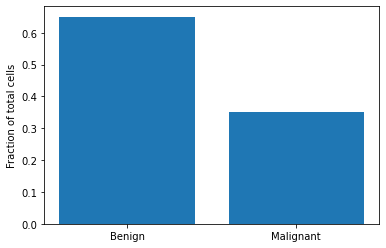

In [227]:
# Separate data based on class
normal = new_data[new_data["Class"] == 2]
abnormal = new_data[new_data["Class"] == 4]

# Determine class distribution
num_N = normal.shape[0] # 458
num_A = abnormal.shape[0] # 241
frac_N = num_N/new_data.shape[0] 
frac_A = num_A/new_data.shape[0]

# Plot class distribution
f, ax = plt.subplots()
plt.bar([1,2],[frac_N,frac_A])
plt.ylabel("Fraction of total cells")
ax.set_xticks([1,2])
ax.set_xticklabels(["Benign","Malignant"])
plt.show()

There is a slight class imbalance (65% of cells are benign, 35% are malignant). Depending on model performance, we may need to upsample from the minority (malignant) class or downsample from the majority (benign) class to deal with this.

Lets see if the distribution of each feature changes based on the class it belongs to (if the cell is benign or malignant).

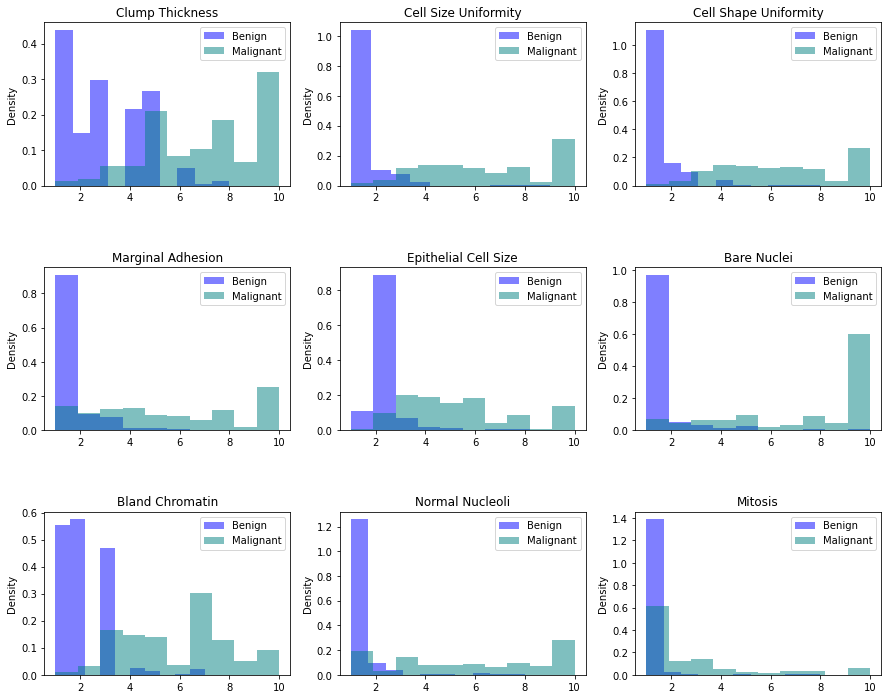

In [228]:
# Plot a histogram of each feature separated by class
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(features):
    ax = plt.subplot(3, 3, i + 1)
    N = normal[col]
    A = abnormal[col]
    #ax.set_xticks([1,2])
    #ax.set_xticklabels(["Benign","Malignant"])
    plt.ylabel('Density')
    plt.hist(N,density=True,label = "Benign",bins = 10,fc=(0, 0, 1, 0.5))
    plt.hist(A,density=True,label = "Malignant",bins = 10,fc=(0, 0.5, 0.5, 0.5))
    plt.title(col)
    plt.legend()
plt.show()

As shown in the above plot, benign cells typically have a lower mean and variance than malignant cells for all features.
Importantly, the distributions of all features are significantly different for both classes. This indicates that all of them are predictors of tumor type, i.e. none of them should be removed from the data set prior to training.

The differences in class mean and standard deviation are more clearly plotted below. 

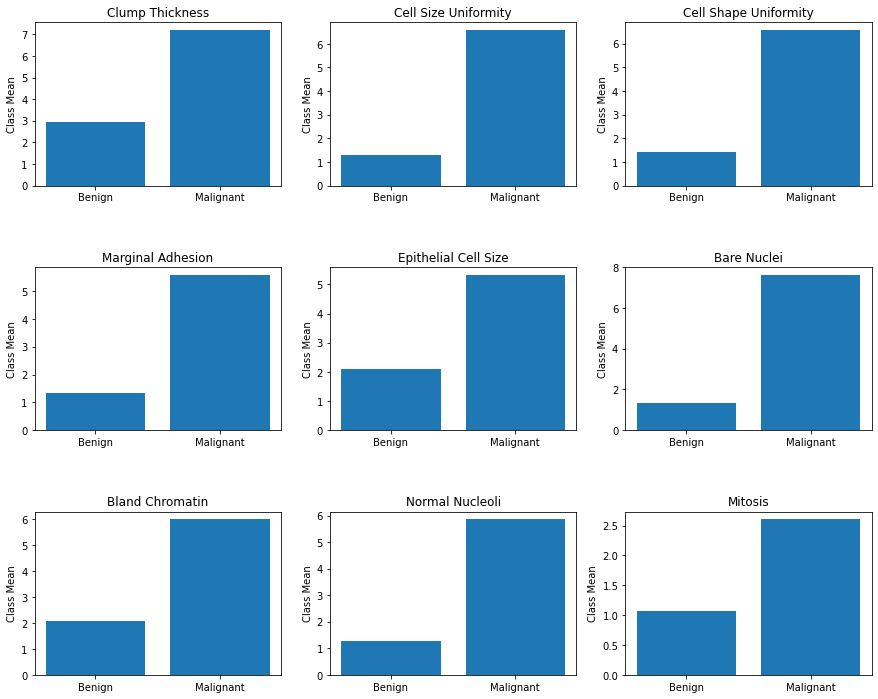

In [229]:
# Mean
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(features):
    ax = plt.subplot(3, 3, i + 1)
    N = normal[col]
    A = abnormal[col]
    ax.set_xticks([1,2])
    ax.set_xticklabels(["Benign","Malignant"])
    plt.ylabel('Class Mean')
    plt.bar([1,2],[np.mean(N),np.mean(A)])
    plt.title(col)
plt.show()

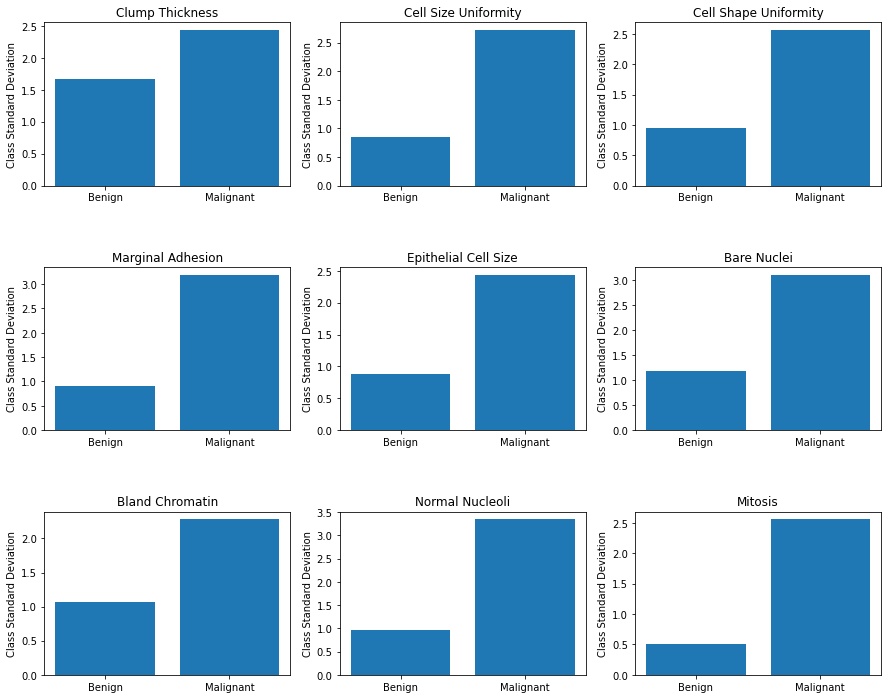

In [230]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(features):
    ax = plt.subplot(3, 3, i + 1)
    N = normal[col]
    A = abnormal[col]
    ax.set_xticks([1,2])
    ax.set_xticklabels(["Benign","Malignant"])
    plt.ylabel('Class Standard Deviation')
    plt.bar([1,2],[np.std(N),np.std(A)])
    plt.title(col)
plt.show()

# Model Building and Training

Let us first see how a simple logistic regression model performs. If the simplest model does not perform well, we can modify it as needed. 
Some modifications could include: balancing class sizes before training, adding regularization, using a more complex model. 

Generate feature matrix X and label vector y

In [231]:
# Randomize rows in case there is any class ordering
df_rand = new_data.sample(frac=1).reset_index(drop=True)

# Replace benign class label with 0, abnormal class label with 1
df_rand["Class"].replace({2: 0, 4: 1}, inplace=True)

# Separate independent variables and dependent variable
X = df_rand.drop(columns = ["ID Number","Class"]).to_numpy()
y = df_rand["Class"]

Let's build and train our model using 10-fold cross validation

In [232]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression

In [234]:
# Prepare cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# Create model
model_cv = LogisticRegression()
# Evaluate model
scores_f1 = cross_val_score(model_cv, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(model_cv, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# Report performance
print('Accuracy Mean (Standard Deviation): %.3f (%.3f)' % (np.mean(scores_acc),np.std(scores_acc)))
print('F1 Score Mean (Standard Deviation): %.3f (%.3f)' % (np.mean(scores_f1),np.std(scores_f1)))

Accuracy Mean (Standard Deviation): 0.968 (0.019)
F1 Score Mean (Standard Deviation): 0.955 (0.026)


We use F1 score in addition to accuracy to evaluate the model's performance given the slight class imbalance.
We see that both accuracy and F1 score are in the high 90's. A simple model worked just fine. 

As a next step, it may be interesting to see how a decision tree performs on this data set. Such a model would provide insight into which features were the most important predictors of tumor type.